In [0]:
#TODO: save model, plot curves

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!unzip "/content/office.zip" # upload ZIP from computer
# !unzip "/content/drive/My Drive/office.zip" --> NOT UNZIPING FULL SET

Archive:  /content/office.zip
   creating: office/
   creating: office/webcam/
   creating: office/dslr/
   creating: office/amazon/
   creating: office/webcam/images/
   creating: office/dslr/images/
   creating: office/amazon/images/
   creating: office/webcam/images/trash_can/
  inflating: office/webcam/images/trash_can/frame_0021.jpg  
  inflating: office/webcam/images/trash_can/frame_0020.jpg  
  inflating: office/webcam/images/trash_can/frame_0019.jpg  
  inflating: office/webcam/images/trash_can/frame_0018.jpg  
  inflating: office/webcam/images/trash_can/frame_0017.jpg  
  inflating: office/webcam/images/trash_can/frame_0016.jpg  
  inflating: office/webcam/images/trash_can/frame_0015.jpg  
  inflating: office/webcam/images/trash_can/frame_0014.jpg  
  inflating: office/webcam/images/trash_can/frame_0013.jpg  
  inflating: office/webcam/images/trash_can/frame_0012.jpg  
  inflating: office/webcam/images/trash_can/frame_0011.jpg  
  inflating: office/webcam/images/trash_can/fram

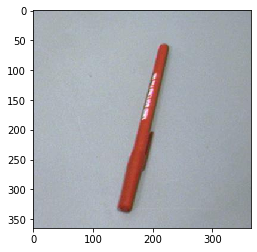

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# verify image has been uploaded correctly to colab
img = cv2.imread("/content/office/webcam/images/pen/frame_0002.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [72]:
import torch
import os

print(">>> Colab CUDA info <<<")
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

>>> Colab CUDA info <<<
0
1
Tesla P4
True


In [74]:
# as of now: run model twice: w and w/o domain adaptation
# !python /content/main.py --epochs 2 --batch_size_source 64 --batch_size_target 32 --adapt_domain
!python /content/main.py --epochs 2 --batch_size_source 64 --batch_size_target 32

creating source/target dataloaders...
source data: amazon
target data: webcam
using cuda...
loading pre-trained AlexNet...
loaded model correctly...
model type: <class 'model.DeepCORAL'>
adapt domain: False
running training for 2 epochs...
CUDA: True
Train Epoch:  1 [ 1/25]	Lambda value: 0.0000, Classification loss: 3.517962, CORAL loss: 0.000016, Total_Loss: 3.517962
CUDA: True
Train Epoch:  1 [ 2/25]	Lambda value: 0.0000, Classification loss: 3.376334, CORAL loss: 0.000016, Total_Loss: 3.376334
CUDA: True
Train Epoch:  1 [ 3/25]	Lambda value: 0.0000, Classification loss: 2.680067, CORAL loss: 0.000278, Total_Loss: 2.680067
CUDA: True
Train Epoch:  1 [ 4/25]	Lambda value: 0.0000, Classification loss: 2.407471, CORAL loss: 0.001836, Total_Loss: 2.407471
CUDA: True
Train Epoch:  1 [ 5/25]	Lambda value: 0.0000, Classification loss: 2.421475, CORAL loss: 0.002247, Total_Loss: 2.421475
CUDA: True
Train Epoch:  1 [ 6/25]	Lambda value: 0.0000, Classification loss: 1.659797, CORAL loss: 0.033

In [0]:
# 6 dictionaries
#################################################################################
# adapt_training_dict --> coral_loss, class_loss (for each batch idx (all epochs))
# get mean coral_loss and class_loss given steps for each epoch --> DONE

# adapt_testing_source_dict --> training acc (w coral loss)
# get accuracy directly

# adapt_testing_target_dict --> testing acc (w coral loss)
# get accuracy directly

#################################################################################
# no_adapt_training_dict --> coral_loss, class_loss (for each batch idx (all epochs))
# get mean coral_loss and class_loss given steps for each epoch

# no_adapt_testing_source_dict --> training acc (w/o coral loss)
# get accuracy directly

# no_adapt_testing_target_dict --> testing acc (w/o coral loss)
# get accuracy directly

In [0]:
def plot_loss_acc():
  pass

In [0]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

# load dictionaries with log information
path_adapt_log = ["/content/adaptation_training_statistic.pkl",
                  "/content/adaptation_testing_s_statistic.pkl",
                  "/content/adaptation_testing_t_statistic.pkl"]

path_no_adapt_log = ["/content/no_adaptation_training_statistic.pkl",
                     "/content/no_adaptation_testing_s_statistic.pkl",
                     "/content/no_adaptation_testing_t_statistic.pkl"]

adapt_training_dict = pickle.load(open(path_adapt_log[0], 'rb'))
adapt_testing_source_dict = pickle.load(open(path_adapt_log[1], 'rb'))
adapt_testing_target_dict = pickle.load(open(path_adapt_log[2], 'rb'))

no_adapt_training_dict = pickle.load(open(path_no_adapt_log[0], 'rb'))
no_adapt_testing_source_dict = pickle.load(open(path_no_adapt_log[1], 'rb'))
no_adapt_testing_target_dict = pickle.load(open(path_no_adapt_log[2], 'rb'))

In [0]:
adaptation = {
    "classification_loss": [],
    "coral_loss": [],
    "source_accuracy": [],
    "target_accuracy": []
}

no_adaptation = {
    "source_accuracy": [],
    "target_accuracy": []
}

In [0]:
# get average coral and classification loss for steps in each epoch
for epoch_idx in range(len(adapt_training_dict)): # epoch
  coral_loss = 0
  class_loss = 0

  for step_idx in range(len(adapt_training_dict[epoch_idx])):
    coral_loss += adapt_training_dict[epoch_idx][step_idx]["coral_loss"]
    class_loss += adapt_training_dict[epoch_idx][step_idx]["classification_loss"]

  # store average losses and accuracies in adaptation dictionary
  adaptation["classification_loss"].append(class_loss/len(adapt_training_dict[epoch_idx]))
  adaptation["coral_loss"].append(coral_loss/len(adapt_training_dict[epoch_idx]))
  adaptation["source_accuracy"].append(adapt_testing_source_dict[epoch_idx]["accuracy %"])
  adaptation["target_accuracy"].append(adapt_testing_target_dict[epoch_idx]["accuracy %"])

  # store accuracies in no-adaptation dictionary
  no_adaptation["source_accuracy"].append(no_adapt_testing_source_dict[epoch_idx]["accuracy %"])
  no_adaptation["target_accuracy"].append(no_adapt_testing_target_dict[epoch_idx]["accuracy %"])

In [91]:
print(adaptation)
print(no_adaptation)

{'classification_loss': [1.6819099068641663, 0.7938931322097779], 'coral_loss': [0.05714778977213428, 0.03264087252318859], 'source_accuracy': [77.31629180908203, 86.01348876953125], 'target_accuracy': [41.132076263427734, 41.50943374633789]}
{'source_accuracy': [76.64181518554688, 86.26197814941406], 'target_accuracy': [42.89308166503906, 41.38364791870117]}
